In [15]:
#библиотеки
from sklearn.metrics import r2_score
import pandas as pd
import sqldf
import catboost as cb
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime


#Предобработка данных
data0 = pd.read_excel('2018.xlsx')
data1 = pd.read_excel('2019.xlsx')
data2 = pd.read_excel('2020.xlsx')

data = pd.concat([
    data0,
    data1,
    data2
])

data = data.replace(" 00:00:00.000", '', regex = True)

data = data.drop(['ЦЗ',"ЗСП", "План СЭС, МВт*ч",'План ВЭС, МВт*ч' ,'План ВИЭ, МВт*ч' ,'Ценопринимание сверх минимальной мощности, МВт*ч'], axis=1)

data = data.rename(columns={"Дата": "Date", "Час": "Hour", "План АЭС, МВт*ч": "Npp_plan", "План ТЭС, МВт*ч": "Tpp_plan", "План ГЭС, МВт*ч": "Hpp_plan", "ТЭС мин, МВт*ч": "Tpp_min", "ТЭС макс, МВт*ч": "Tpp_max", "Потребление, МВт*ч": "consumption", "Экспорт, МВт*ч": "export", "Импорт, МВт*ч": "import", "Ценопринимающее предложение, МВт*ч": "Price_proposal", "Цена продажи, руб./МВт*ч": "total_price"})

data = sqldf.run('''SELECT Date, SUM(Hpp_plan) AS Hpp_plan, SUM(Npp_plan) AS Npp_plan, SUM(Tpp_plan) AS Tpp_plan, SUM(Tpp_min) AS Tpp_min, SUM(Tpp_max) AS Tpp_max, SUM(consumption) AS consumption, SUM(export) AS export, SUM(import) AS import, AVG(Price_proposal) AS price_proposal, AVG(total_price) AS total_price FROM data WHERE total_price > 100 GROUP BY Date, Hour ORDER BY Date, Hour ASC;''')

test_data = sqldf.run('''SELECT * FROM data WHERE data.Date >= '2020-07-24' AND data.Date <= '2020-08-24';''')

train_data = pd.concat([data,test_data]).drop_duplicates(subset=["Date","Hpp_plan","Npp_plan","Tpp_plan","Tpp_min","Tpp_max","consumption","export","import","price_proposal","total_price"], keep=False)

train_data = train_data.drop("index", axis = 1)
test_data = test_data.drop("index", axis = 1)

In [16]:
#Разделение данных на обучающуюся и тестовую выборку
Train_date = train_data['Date']
Test_date = test_data['Date']
X_train, y_train = train_data[['Hpp_plan', 'Npp_plan', 'Tpp_plan', 'Tpp_min', 'Tpp_max', 'consumption', 'export', 'import', 'price_proposal']], train_data[['total_price']] 
X_test, y_test = test_data[['Hpp_plan', 'Npp_plan', 'Tpp_plan', 'Tpp_min', 'Tpp_max', 'consumption', 'export', 'import', 'price_proposal']], test_data[['total_price']]

In [ ]:
#Перевод данных в нужный формат обучение модели
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function = "RMSE")
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

In [18]:
#Метрики
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))


Testing performance
RMSE: 46.78
R2: 0.96


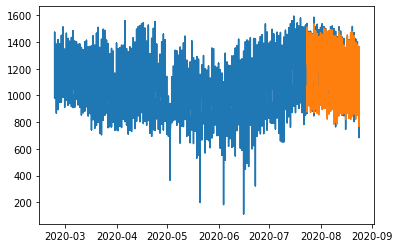

In [19]:
#Визуализация за последние 6 месяцев (синим актуальная цена за 6 месяцев, оранжевым предсказанные значения за последний месяц)
tmp = sqldf.run('''SELECT Date, total_price FROM data WHERE data.Date >= '2020-02-24' AND data.Date <= '2020-08-24';''')
date = tmp['Date'].to_numpy()
price = tmp['total_price'].to_numpy()
df = pd.DataFrame(pred, index=pd.to_datetime(Test_date))
df2 = pd.DataFrame(price, index=pd.to_datetime(date))

plt.plot(df2)
plt.plot(df)
